<a href="https://colab.research.google.com/github/guevelel/COMP4449_Plume_Analysis/blob/main/P7_Plume_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Final - Term Project 7: Mystery at the Wildlife Preserve (Plume Analysis)
## Edward Guevel


####Goals

1- Characterize the sensors’ performance and operation. Are they all working properly at all times? Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture?

2- Now turn your attention to the chemicals themselves. Which chemicals are being detected by the sensor group? What patterns of chemical releases do you see, as being reported in the data?

3- Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.

In [1]:
#QUESTIONS:
#aggregate sensor data avg rating per chemical per sensor
#
#

In [43]:
!pip3 install dash --upgrade
!pip install jupyter-dash --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [5]:
#Import required libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import files
import io

In [26]:
#Upload files from computer:

uploaded = files.upload()

Saving SensorData.csv to SensorData.csv


In [102]:
#Write files to pandas DF:
meteor = pd.read_csv('MeteorologicalData_edited.csv')
#meteor = pd.read_csv(io.BytesIO(uploaded['MeteorologicalData.xlsx']))
sensor = pd.read_csv('SensorData.csv')

In [95]:
meteor.head()

,Date,Wind Direction,Wind Speed (m/s),Unnamed: 3,Unnamed: 4
0,4/1/16 0:00,190.5,4.0,NaN,NaN
1,4/1/16 3:00,203.3,5.0,NaN,NaN
2,4/1/16 6:00,201.1,5.2,NaN,NaN
3,4/1/16 9:00,204.9,4.1,NaN,NaN
4,4/1/16 12:00,207.0,3.6,NaN,NaN


In [96]:
sensor.head()

,Chemical,Monitor,Date Time,Reading
0,Methylosmolene,3,4/1/16 0:00,2.683820
1,Methylosmolene,7,4/1/16 0:00,2.630640
2,Chlorodinine,3,4/1/16 0:00,1.259170
3,Chlorodinine,7,4/1/16 0:00,0.943983
4,AGOC-3A,3,4/1/16 0:00,0.722303


In [103]:
#meteor['Unnamed: 3'].values.sum()
meteor.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)
#sensor = sensor.rename(columns={'Date Time ': 'date'}, inplace=True)
sensor.rename(columns = {'Date Time ': 'date'}, inplace=True)

meteor.head()
sensor.head()

,Chemical,Monitor,date,Reading
0,Methylosmolene,3,4/1/16 0:00,2.683820
1,Methylosmolene,7,4/1/16 0:00,2.630640
2,Chlorodinine,3,4/1/16 0:00,1.259170
3,Chlorodinine,7,4/1/16 0:00,0.943983
4,AGOC-3A,3,4/1/16 0:00,0.722303


In [104]:
#Create list of sensor coordinates:
sensor_coords = {1:[62,21],2:[66,35],3:[76,41],
                 4:[88,45],5:[103,43], 6:[102,22],
                 7:[89,3],8:[74,7],9:[119,42]}

#Append sensor_coords to sensor dataframe:
def add_x_coords(row):
  return sensor_coords[row['Monitor']][0]
def add_y_coords(row):
  return sensor_coords[row['Monitor']][1]
  
sensor['x'] = sensor.apply(lambda row: add_x_coords(row), axis=1)
sensor['y'] = sensor.apply(lambda row: add_y_coords(row), axis=1)

sensor.head()

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,4/1/16 0:00,2.683820,76,41
1,Methylosmolene,7,4/1/16 0:00,2.630640,89,3
2,Chlorodinine,3,4/1/16 0:00,1.259170,76,41
3,Chlorodinine,7,4/1/16 0:00,0.943983,89,3
4,AGOC-3A,3,4/1/16 0:00,0.722303,76,41


In [105]:
#Check for missing values:
#sensor.isnull().sum()
meteor.isnull().sum()

#Drop null values from Meteorological Data, since so few values:
meteor.dropna(axis=0, inplace=True)
meteor.isnull().sum()


Date                0
Wind Direction      0
Wind Speed (m/s)    0
dtype: int64

In [81]:
sensor['date'][0]

Timestamp('2016-04-01 00:00:00')

In [108]:
#type(sensor['Date Time '][2])
#sensor.columns
#

#Convert string dates to date-time objects:
sensor['date'] = pd.to_datetime(sensor['date'], format="%m/%d/%y %H:%M")

meteor['Date'] = pd.to_datetime(meteor['Date'] , format="%m/%d/%y %H:%M")

sensor.head()
#meteor.head()
#type(sensor['Date Time '][2])

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,2016-04-01,2.683820,76,41
1,Methylosmolene,7,2016-04-01,2.630640,89,3
2,Chlorodinine,3,2016-04-01,1.259170,76,41
3,Chlorodinine,7,2016-04-01,0.943983,89,3
4,AGOC-3A,3,2016-04-01,0.722303,76,41


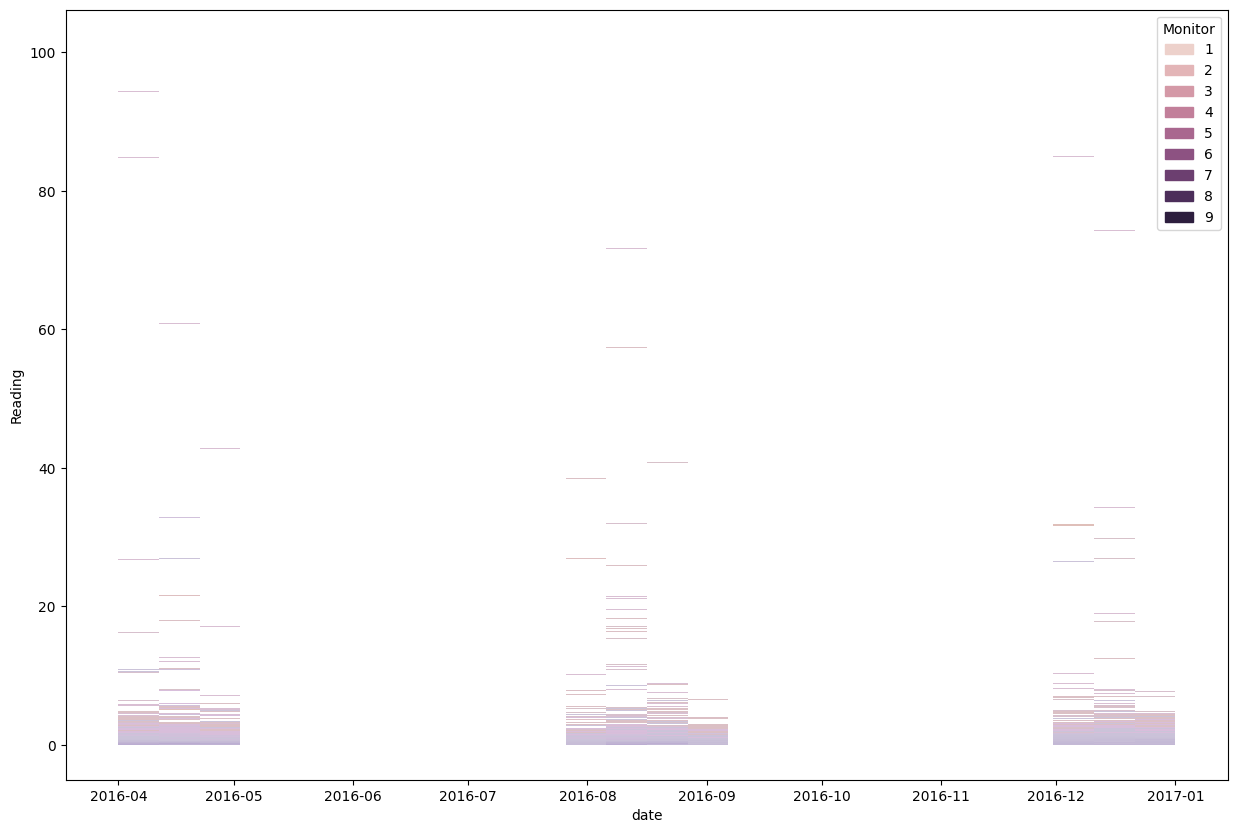

In [112]:
#Histogram of the sensor data:
plt.figure(figsize=(15,10))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
#sns.scatter
plt.show()



We can see that the sensors were only collecting data in certain time ranges...

In [126]:
#look at april-may sensor data:
import datetime
#apr_sensor = sensor[datetime.datetime.strptime(sensor["date"],"%d/%m/%Y") < datetime.date(5/1/2016)]
#apr_sensor.head()
apr_sensor = sensor.iloc[0:25847]
oct_sensor = sensor.iloc[25848:52525]
dec_sensor = sensor.iloc[52526:]

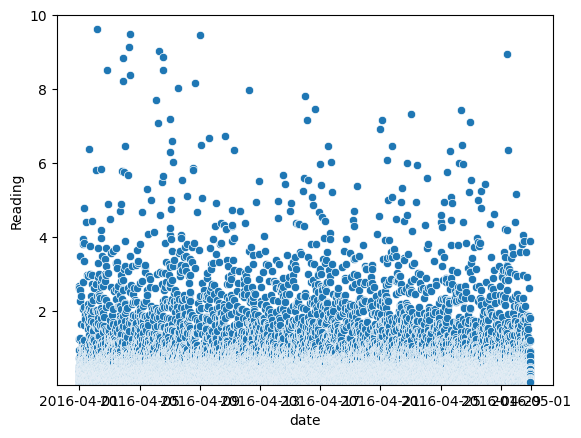

In [131]:
sns.scatterplot(apr_sensor, x=apr_sensor['date'],y=apr_sensor['Reading'])
plt.ylim(bottom = .01,top=10)
plt.show()

In [139]:
#temp = np.where(apr_sensor['Monitor']==1)
temp = apr_sensor[apr_sensor['Monitor']==1]
temp['date']

11      2016-04-01 00:00:00
13      2016-04-01 00:00:00
23      2016-04-01 00:00:00
35      2016-04-01 00:00:00
49      2016-04-01 01:00:00
                ...        
25810   2016-04-30 22:00:00
25826   2016-04-30 23:00:00
25831   2016-04-30 23:00:00
25839   2016-04-30 23:00:00
25843   2016-04-30 23:00:00
Name: date, Length: 2872, dtype: datetime64[ns]

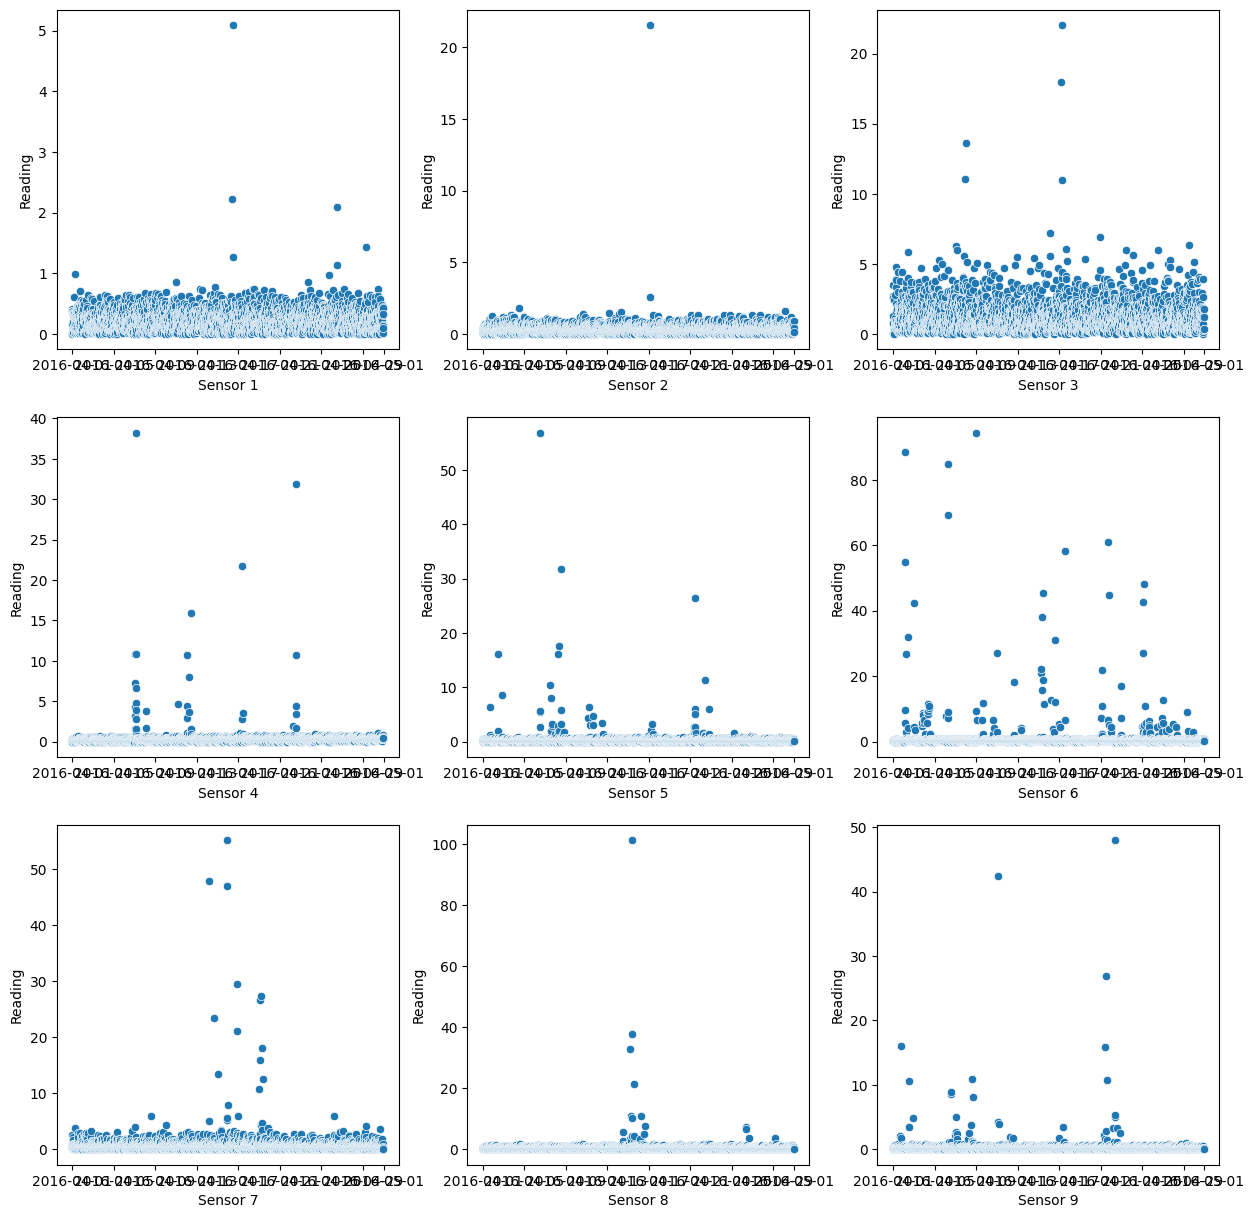

In [142]:
#Update headers, labels, and add graphs for the other two sensors

plt.figure(figsize=(15,15))
for i in range(1,10):
  plt.subplot(3,3,i)
  #plt.xticks([])
  #plt.yticks([])
  #plt.grid(False)
  temp = apr_sensor[apr_sensor['Monitor']==i]
  #apr_sensor
  sns.scatterplot(temp, x=temp['date'], y=temp['Reading'])
  #titles = np.where(train['labels']==i)
  #index = titles[0][50]
  #plt.imshow(train['features'][index], cmap=plt.cm.binary)
  plt.xlabel(f'Sensor {i}')
plt.show()


In [154]:
from statistics import mean, median
sensor.groupby(['Monitor', 'Chemical']).agg({'Reading': [min, max, mean, median]}) #Reading

Reading                               
                             min        max      mean    median
Monitor Chemical                                               
1       AGOC-3A         0.001065   31.66583  0.253239  0.206802
        Appluimonia     0.001130    2.96613  0.236594  0.208838
        Chlorodinine    0.001015    5.09007  0.250460  0.216412
        Methylosmolene  0.001003   31.80997  0.244791  0.207935
2       AGOC-3A         0.001598   31.87868  0.424909  0.298314
        Appluimonia     0.001322    1.97971  0.356967  0.309486
        Chlorodinine    0.001633   15.72311  0.368848  0.306396
        Methylosmolene  0.001591   58.46353  0.417800  0.303303
3       AGOC-3A         0.001257   85.31459  1.662681  1.033910
        Appluimonia     0.001899    7.16925  1.272462  0.983202
        Chlorodinine    0.001661    8.96003  1.298497  1.012320
        Methylosmolene  0.002452   75.96199  1.440209  0.991337
4       AGOC-3A         0.001833   65.71898  1.506859  1.130980
        Appluimonia     0.001054    4.86055  1.136383  1.098980
        Chlorodinine    0.002067   14.58982  1.227665  1.112270
        Methylosmolene  0.001067   38.21998  1.226446  1.107510
5       AGOC-3A         0.001235   84.63599  0.925276  0.358973
        Appluimonia     0.001154    7.74279  0.466799  0.340357
        Chlorodinine    0.001040   11.74958  0.508499  0.329640
        Methylosmolene  0.001876   53.64960  0.549329  0.343079
6       AGOC-3A         0.001187   84.82578  1.293924  0.412148
        Appluimonia     0.003286   10.14769  0.425051  0.399059
        Chlorodinine    0.002921   15.04032  0.675099  0.413788
        Methylosmolene  0.001418  100.77640  0.963860  0.398255
7       AGOC-3A         0.001574   47.05521  0.699297  0.432167
        Appluimonia     0.002178    4.84236  0.599914  0.435182
        Chlorodinine    0.001124   13.40056  0.617630  0.425310
        Methylosmolene  0.001060   63.31599  0.732663  0.408280
8       AGOC-3A         0.001025  101.10558  0.563217  0.432272
        Appluimonia     0.001277    4.87418  0.476935  0.434267
        Chlorodinine    0.001076    7.44058  0.480803  0.421169
        Methylosmolene  0.001448   32.82523  0.494993  0.417891
9       AGOC-3A         0.001790   47.95602  0.701046  0.294624
        Appluimonia     0.001334    8.51651  0.422416  0.292228
        Chlorodinine    0.001216    5.03405  0.368854  0.280992
        Methylosmolene  0.001241   42.51119  0.416780  0.281561

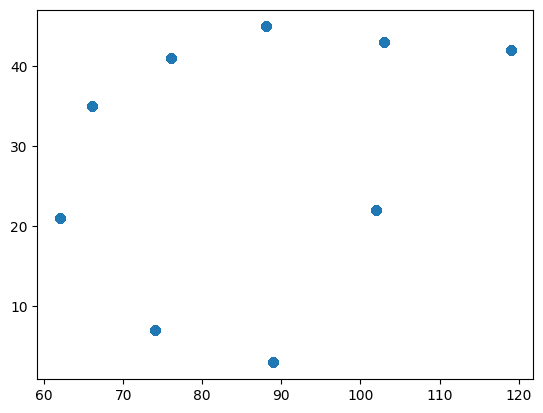

In [42]:
plt.scatter(x=sensor['x'], y=sensor['y'])
plt.show()

In [45]:
import plotly.express as px
import plotly.io as pio
from dash import Dash
from dash import dcc, html
from dash import Input, Output
from jupyter_dash import JupyterDash
pio.renderers.default = "notebook_connected"

In [46]:
fig = px.scatter(sensor, x="x", y="y",
                 size="Reading", color="Chemical", hover_name="Chemical",
                 size_max=20)

app = JupyterDash()

app.layout = html.Div([
    dcc.Graph(
        id='sensor-reading',
        figure=fig
    )
])

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [ ]:


#app = dash.Dash(name)
app = Dash(name)

app.layout = html.Div(style={‘background-image’: ‘url(“diginex.png”)’,
                             ‘background-repeat’: ‘no-repeat’,
                             ‘background-position’: ‘right top’,
                             ‘background-size’: ‘150px 100px’},
                      children = [html.H1(‘Hello World’),
                                  html.P(‘This image has an image in the background’)])

app.run_server(port = 8059)